In [1]:
!pip install pandas
from IPython.display import display
import pandas as pd 
import pickle
import os 
from utils.env import EvoD4jEnv
import re 

You should consider upgrading via the '/home/coinse/.pyenv/versions/3.8.10/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
def get_data(project, version, ts_id, prompt_no, example_num, all_df, transformed=False):
    env = EvoD4jEnv(project, version, ts_id)
    # Original 
    if transformed == False:
        original_chat_reply_root_path = env.selected_evosuite_chat_reply_dir.replace("/root/workspace","/home/coinse/Workspace/hslee_workspace/autooracle/workspace")
        gt = "correct"
        predict_str = "predict_org"
    # Transformed
    else:
        original_chat_reply_root_path = env.selected_evosuite_chat_reply_mut_dir.replace("/root/workspace","/home/coinse/Workspace/hslee_workspace/autooracle/workspace")
        gt = "incorrect"
        predict_str = "predict_trs"
    try_df_list = []
    for try_no in range(1,4):
        try_df = pd.DataFrame()
        original_chat_reply_path = os.path.join(original_chat_reply_root_path, f"prompt{prompt_no}/example{example_num}/try{try_no}")
        for file_name in os.listdir(original_chat_reply_path):
            split_file_name = file_name.split('_')
            oracle_type = split_file_name[-1][:-4]
            test_class = split_file_name[0]
            test_no = split_file_name[1]
            if oracle_type=="assert" or oracle_type=="trycatch":
                with open(os.path.join(original_chat_reply_path, file_name)) as f:
                    reply = f.read()
                if re.search("undecidable", reply):
                    predict = "undecidable"
                elif re.search("incorrect", reply):
                    predict = "incorrect"
                elif re.search("correct", reply):
                    predict = "correct"
                else: continue
                df = pd.DataFrame({"project":[project], "version":[version], "ts_id":[ts_id], "test_class":[test_class], "test_no":[test_no], "type":[oracle_type], "gt":[gt], predict_str+f'_try{try_no}':[predict]})
                try_df=pd.concat([try_df,df])
        try_df_list.append(try_df)
    print(version)
    
    merge_try_dfs = pd.merge(left=try_df_list[0], right=try_df_list[1], on=["project", "version", "ts_id", "test_class", "test_no", "type", "gt"])
    merge_try_dfs = pd.merge(left=merge_try_dfs, right=try_df_list[2], on=["project", "version", "ts_id", "test_class", "test_no", "type", "gt"])
    
    all_df = pd.concat([all_df, merge_try_dfs])
    return all_df

In [3]:
def failing_test(project, version, ts_id, all_df, transformed=False):
    env = EvoD4jEnv(project, version, ts_id)
    failing_test_path = env.evosuite_test_dir.replace("/root/workspace","/home/coinse/Workspace/hslee_workspace/autooracle/workspace")
    with open(os.path.join(failing_test_path, "failing_tests_on_fixed")) as f:
        content = f.readlines()
    fail_test_class =''
    for l in content:
        if l.startswith('---'):
            pattern = r"--- (.*?)::(.*?)$"
            match = re.search(pattern, l)
            if match:
                split_fail_test_class = match.group(1).split('.')
                fail_test_class = '.'.join(split_fail_test_class[:-1])
                fail_test_no = match.group(2).strip()
                if fail_test_no[4]=='0' and len(fail_test_no)>5:
                    fail_test_no = fail_test_no[:4]+fail_test_no[5]
                # Original 
                if transformed == False:
                    gt = "incorrect"
                # Transformed
                else:
                    gt = "correct"
                # print(version)
                # print(fail_test_class)
                # print(fail_test_no)
                all_df.loc[(all_df["version"]==version)&(all_df["test_class"]==fail_test_class)&(all_df["test_no"]==fail_test_no),"gt"] = gt
    return all_df

In [4]:
def get_dataframe(project, ts_id, prompt_no, example_num, versions, except_versions =[]):
    project = project
    ts_id = ts_id
    prompt_no = prompt_no
    example_num = example_num

    org_df=pd.DataFrame()
    trs_df=pd.DataFrame()

    for version in versions:
        if version in except_versions:
            continue
        org_df=get_data(project, version, ts_id, prompt_no, example_num, org_df, transformed=False)
        org_df=failing_test(project, version, ts_id, org_df, transformed=False)
        
        trs_df=get_data(project, version, ts_id, prompt_no, example_num, trs_df, transformed=True)
        trs_df=failing_test(project, version, ts_id, trs_df, transformed=True)

    org_df=org_df.rename(columns={'gt':'gt_org'})
    trs_df=trs_df.rename(columns={'gt':'gt_trs'})

    all_df=pd.merge(left=org_df,right=trs_df,on=["project", "version", "ts_id", "test_class", "test_no", "type"])
    # all_df.drop(all_df[(all_df['predict_org_try1']=='undecidable') | (all_df['predict_org_try2']=='undecidable') |(all_df['predict_org_try3']=='undecidable') |(all_df['predict_trs_try1']=='undecidable') | (all_df['predict_trs_try2']=='undecidable') | (all_df['predict_trs_try3']=='undecidable')].index, inplace=True)
    all_df["Predict"] = 0
    for j in range(1,4):
        all_df.loc[all_df["predict_org_try{}".format(j)] == "correct", "Predict"] += 1
        all_df.loc[all_df["predict_org_try{}".format(j)] == "incorrect", "Predict"] -= 1
        all_df.loc[all_df["predict_org_try{}".format(j)] == "undecidable", "Predict"] += 0
        all_df.loc[all_df["predict_trs_try{}".format(j)] == "correct", "Predict"] -= 1
        all_df.loc[all_df["predict_trs_try{}".format(j)]  == "incorrect", "Predict"] += 1
        all_df.loc[all_df["predict_trs_try{}".format(j)]  == "undecidable", "Predict"] += 0

    return all_df

In [5]:
# Chart_df = get_dataframe("Chart", "newTS_600", 5, 2, list(range(1, 27)))

Lang_df = get_dataframe("Lang", "newTS_600", 8, 2, list(range(1, 66)), except_versions =[ 2, 4, 19, 26, 28, 30, 38, 43, 48, 53, 55, 63])

# Lang_df = get_dataframe("Lang", "newTS_600", 5, 2, [11,12], except_versions =[2, 30, 63])

Time_df = get_dataframe("Time", "newTS_600", 8, 2, list(range(1, 28)), except_versions =[21])

df_list = [Lang_df, Time_df]
all_df = pd.concat(df_list, ignore_index=True)


1
1
3
3
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
20
20
21
21
22
22
23
23
24
24
25
25
27
27
29
29
31
31
32
32
33
33
34
34
35
35
36
36
37
37
39
39
40
40
41
41
42
42
44
44
45
45
46
46
47
47
49
49
50
50
51
51
52
52
54
54
56
56
57
57
58
58
59
59
60
60
61
61
62
62
64
64
65
65
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
22
22
23
23
24
24
25
25
26
26
27
27


,project,version,ts_id,test_class,test_no,type,gt_org,predict_org_try1,predict_org_try2,predict_org_try3,gt_trs,predict_trs_try1,predict_trs_try2,predict_trs_try3,Predict
0,Lang,1,newTS_600,org.apache.commons.lang3.math,test27,trycatch,correct,correct,undecidable,incorrect,incorrect,incorrect,incorrect,incorrect,3
1,Lang,1,newTS_600,org.apache.commons.lang3,test2,assert,correct,correct,correct,correct,incorrect,correct,incorrect,correct,2
2,Lang,1,newTS_600,org.apache.commons.lang3.math,test31,trycatch,correct,correct,correct,correct,incorrect,incorrect,incorrect,incorrect,6
3,Lang,1,newTS_600,org.apache.commons.lang3,test1,assert,correct,correct,correct,correct,incorrect,correct,correct,correct,0
4,Lang,1,newTS_600,org.apache.commons.lang3.math,test17,trycatch,correct,correct,incorrect,correct,incorrect,incorrect,incorrect,incorrect,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,Time,27,newTS_600,org.joda.time.convert,test1,trycatch,correct,incorrect,incorrect,correct,incorrect,incorrect,correct,correct,-2
1038,Time,27,newTS_600,org.joda.time,test8,assert,correct,correct,correct,correct,incorrect,incorrect,incorrect,correct,4
1039,Time,27,newTS_600,org.joda.time,test5,trycatch,correct,correct,correct,correct,incorrect,correct,correct,incorrect,2
1040,Time,27,newTS_600,org.joda.time.convert,test2,trycatch,correct,correct,correct,correct,incorrect,correct,correct,incorrect,2


,project,version,ts_id,test_class,test_no,type,gt_org,predict_org_try1,predict_org_try2,predict_org_try3,gt_trs,predict_trs_try1,predict_trs_try2,predict_trs_try3,Predict
0,Lang,7,newTS_600,org.apache.commons.lang3.math,test14,assert,incorrect,correct,correct,correct,correct,incorrect,correct,incorrect,4
1,Lang,9,newTS_600,org.apache.commons.lang3.time,test1,trycatch,incorrect,correct,incorrect,correct,correct,incorrect,correct,correct,0
2,Lang,9,newTS_600,org.apache.commons.lang3.time,test2,trycatch,incorrect,correct,correct,incorrect,correct,correct,correct,correct,-2
3,Lang,9,newTS_600,org.apache.commons.lang3.time,test0,trycatch,incorrect,incorrect,correct,correct,correct,correct,incorrect,incorrect,2
4,Lang,11,newTS_600,org.apache.commons.lang3,test19,trycatch,incorrect,incorrect,incorrect,correct,correct,incorrect,correct,correct,-2
5,Lang,11,newTS_600,org.apache.commons.lang3,test10,trycatch,incorrect,correct,correct,correct,correct,correct,correct,correct,0
6,Lang,11,newTS_600,org.apache.commons.lang3,test11,trycatch,incorrect,incorrect,incorrect,incorrect,correct,incorrect,correct,incorrect,-2
7,Lang,11,newTS_600,org.apache.commons.lang3,test17,trycatch,incorrect,incorrect,incorrect,incorrect,correct,correct,correct,incorrect,-4
8,Lang,12,newTS_600,org.apache.commons.lang3,test13,assert,incorrect,correct,incorrect,incorrect,correct,correct,correct,correct,-4
9,Lang,12,newTS_600,org.apache.commons.lang3,test33,assert,incorrect,incorrect,incorrect,incorrect,correct,incorrect,incorrect,incorrect,0


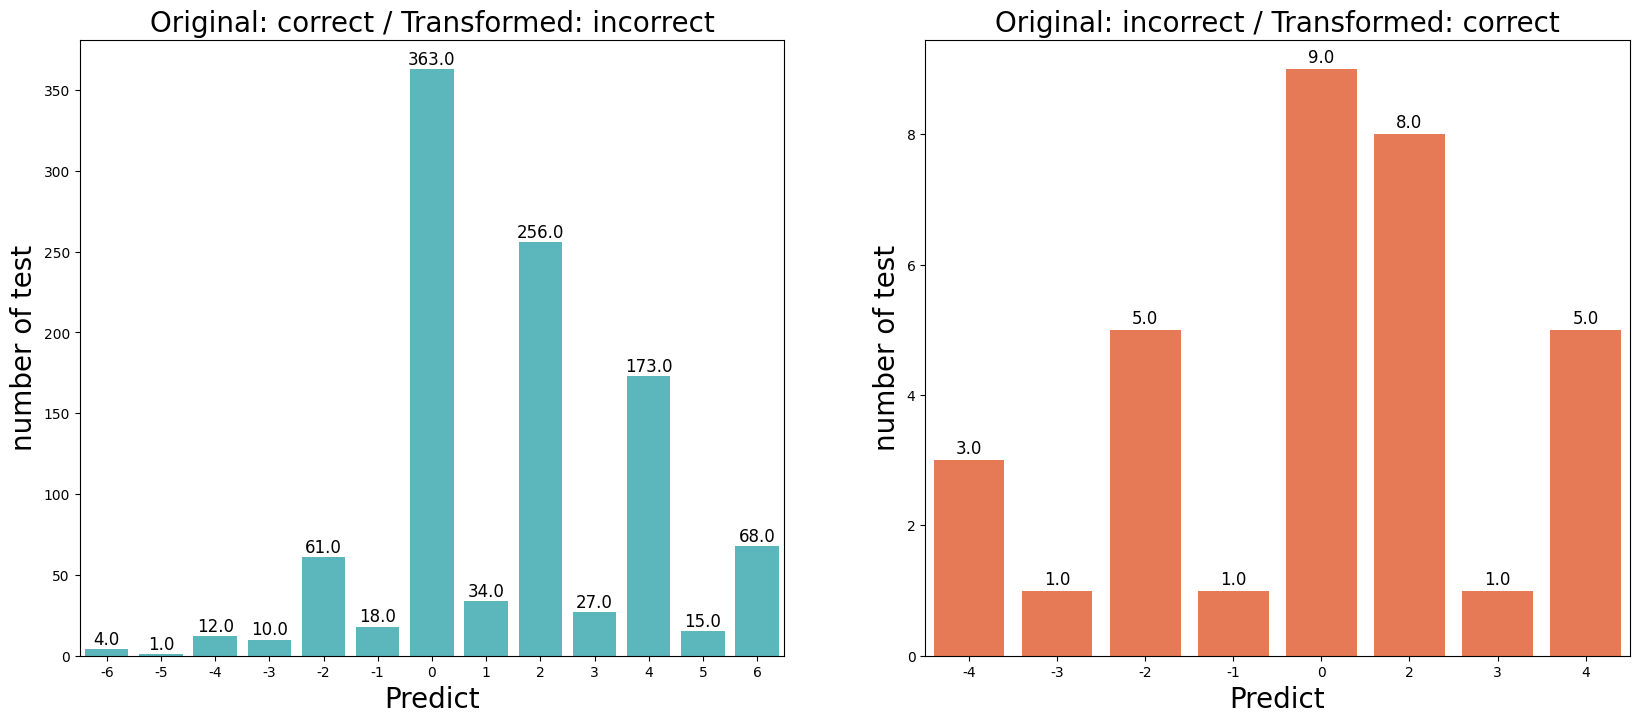

Original: correct / Transformed: incorrect 1.4923224568138196
Original: incorrect / Transformed: correct 0.3939393939393939


In [6]:
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import seaborn as sns

passing_data = all_df.loc[all_df["gt_org"]=="correct",:]
failing_data = all_df.loc[all_df["gt_org"]=="incorrect",:]
display(passing_data.reset_index(drop=True))
display(failing_data.reset_index(drop=True))

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
plt.title("Original: correct / Transformed: incorrect", fontdict = {'fontsize' : 20})
a = sns.countplot(data=passing_data, x="Predict", color='#4BC6CC')
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

plt.subplot(1,2,2)
plt.title("Original: incorrect / Transformed: correct", fontdict = {'fontsize' : 20})
b= sns.countplot(data=failing_data, x="Predict", color='#FF6E3E')
for p in b.patches:
    height = p.get_height()
    b.text(p.get_x() + p.get_width() / 2., height + 0.1, height, ha = 'center', size = 12)
b.set_xlabel("Predict", fontsize = 20)
b.set_ylabel("number of test", fontsize = 20)

plt.show()

print("Original: correct / Transformed: incorrect", passing_data["Predict"].mean())
print("Original: incorrect / Transformed: correct", failing_data["Predict"].mean())

,project,version,ts_id,test_class,test_no,type,gt_org,predict_org_try1,predict_org_try2,predict_org_try3,gt_trs,predict_trs_try1,predict_trs_try2,predict_trs_try3,Predict
746,Lang,61,newTS_600,org.apache.commons.lang.text,test2,assert,incorrect,correct,incorrect,incorrect,correct,correct,incorrect,incorrect,0
743,Lang,60,newTS_600,org.apache.commons.lang.text,test1,assert,incorrect,incorrect,correct,incorrect,correct,correct,correct,undecidable,-3
742,Lang,60,newTS_600,org.apache.commons.lang.text,test22,assert,incorrect,undecidable,correct,correct,correct,correct,incorrect,incorrect,3
739,Lang,60,newTS_600,org.apache.commons.lang.text,test13,trycatch,incorrect,correct,correct,incorrect,correct,incorrect,correct,incorrect,2
731,Lang,59,newTS_600,org.apache.commons.lang.text,test3,trycatch,incorrect,incorrect,correct,incorrect,correct,incorrect,incorrect,incorrect,2
693,Lang,57,newTS_600,org.apache.commons.lang,test3,trycatch,incorrect,incorrect,incorrect,correct,correct,incorrect,incorrect,incorrect,2
675,Lang,52,newTS_600,org.apache.commons.lang,test5,assert,incorrect,correct,correct,correct,correct,correct,incorrect,incorrect,4
669,Lang,51,newTS_600,org.apache.commons.lang,test19,trycatch,incorrect,incorrect,incorrect,incorrect,correct,incorrect,incorrect,incorrect,0
629,Lang,47,newTS_600,org.apache.commons.lang.text,test18,trycatch,incorrect,correct,correct,correct,correct,correct,incorrect,correct,2
623,Lang,46,newTS_600,org.apache.commons.lang,test2,assert,incorrect,correct,correct,correct,correct,incorrect,correct,incorrect,4


Text(0, 0.5, 'number of test')

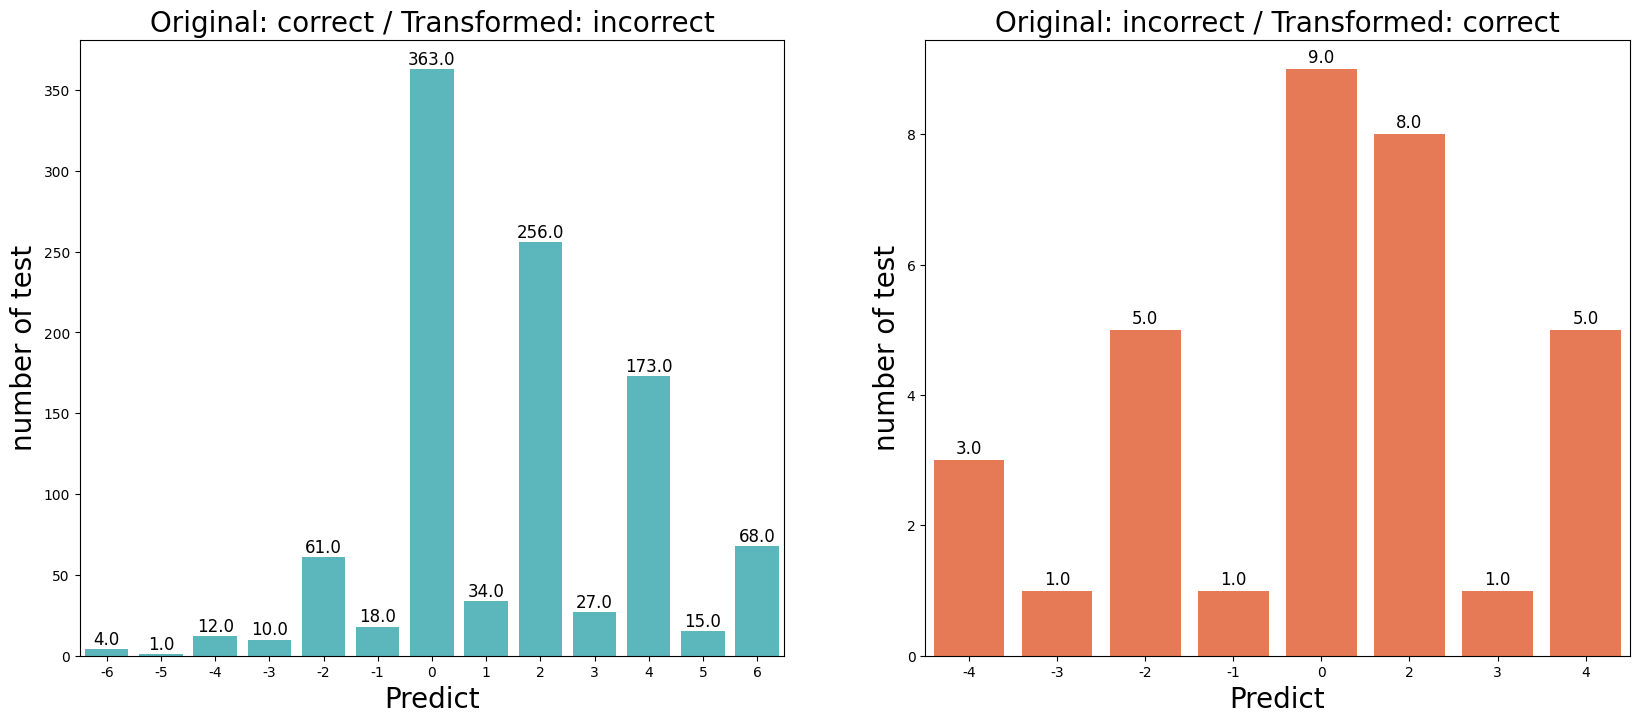

In [7]:
failing_data = all_df.loc[all_df["gt_org"]=="incorrect",:]

display(failing_data.sort_values(by='version', ascending = False))

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
plt.title("Original: correct / Transformed: incorrect", fontdict = {'fontsize' : 20})
a = sns.countplot(data=passing_data, x="Predict", color='#4BC6CC')
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

plt.subplot(1,2,2)
plt.title("Original: incorrect / Transformed: correct", fontdict = {'fontsize' : 20})
b= sns.countplot(data=failing_data, x="Predict", color='#FF6E3E')
for p in b.patches:
    height = p.get_height()
    b.text(p.get_x() + p.get_width() / 2., height + 0.1, height, ha = 'center', size = 12)
b.set_xlabel("Predict", fontsize = 20)
b.set_ylabel("number of test", fontsize = 20)

In [8]:

# prompt_no = 4
# example_num = 2

# for _, row in failing_data.iterrows():
#     pjoject = row['project']
#     version = row['version']
#     ts_id = row["ts_id"]
#     dir=row["test_class"]
#     test_no=row["test_no"]
#     oracle_type=row["type"]

#     individual_id="gpt4_incorrect"

#     for i in range(1,4):
#         try_no=i 

#         script = f"python query.py {pjoject} {version} -i {ts_id} -pn {prompt_no} -en {example_num} -t {try_no} -in -in_id {individual_id} -d {dir} -tn {test_no} -ot {oracle_type}\n"
#         with open('./individual.sh','a') as f:
#             f.write(script)

#         script = f"python query.py {pjoject} {version} -i {ts_id} -pn {prompt_no} -en {example_num} -t {try_no} -m -in -in_id {individual_id} -d {dir} -tn {test_no} -ot {oracle_type}\n"
#         with open('./individual.sh','a') as f:
#             f.write(script)
    

In [9]:
individual_df = pd.DataFrame()
def get_data(individual_id, individual_df, transformed=False):
    indiviual_root_path = os.path.join('/home/coinse/Workspace/hslee_workspace/autooracle/workspace/result/individual',individual_id)
    # Original 
    if transformed == False:
        chat_reply_root_path = os.path.join(indiviual_root_path, 'orginal')
        gt = "incorrect"
        predict_str = "predict_org"
    # Transformed
    else:
        chat_reply_root_path = os.path.join(indiviual_root_path, 'mut')
        gt = "correct"
        predict_str = "predict_trs"

    try_df_list = []    
    for try_no in range(1,4):
        try_df = pd.DataFrame()
        chat_reply_path = os.path.join(chat_reply_root_path, f"try{try_no}")
        for file_name in os.listdir(chat_reply_path):
            split_file_name = file_name.split('_')
            project = split_file_name[0]
            version = split_file_name[1]
            test_class = split_file_name[2]
            test_no = split_file_name[3]
            oracle_type = split_file_name[-1][:-4]
            if oracle_type=="assert" or oracle_type=="trycatch":
                with open(os.path.join(chat_reply_path, file_name)) as f:
                    reply = f.read()
                if re.search("incorrect", reply):
                    predict = "incorrect"
                elif re.search("correct", reply):
                    predict = "correct"
                df = pd.DataFrame({"project":[project], "version":[version], "test_class":[test_class], "test_no":[test_no], "type":[oracle_type], "gt":[gt], predict_str+f'_try{try_no}':[predict]})
                try_df=pd.concat([try_df,df])
        try_df_list.append(try_df)
    
    merge_try_dfs = pd.merge(left=try_df_list[0], right=try_df_list[1], on=["project", "version", "test_class", "test_no", "type", "gt"])
    merge_try_dfs = pd.merge(left=merge_try_dfs, right=try_df_list[2], on=["project", "version", "test_class", "test_no", "type", "gt"])
    
    individual_df = pd.concat([individual_df, merge_try_dfs])
    return individual_df

org_df=pd.DataFrame()
trs_df=pd.DataFrame()
individual_id = "gpt4_incorrect"
org_df=get_data(individual_id, individual_df, transformed=False)
trs_df=get_data(individual_id, individual_df, transformed=True)

org_df=org_df.rename(columns={'gt':'gt_org'})
trs_df=trs_df.rename(columns={'gt':'gt_trs'})

all_df=pd.merge(left=org_df,right=trs_df,on=["project", "version", "test_class", "test_no", "type"])
display(all_df)
all_df["Predict"] = 0
for j in range(1,4):
    all_df.loc[all_df["predict_org_try{}".format(j)] == "correct", "Predict"] += 1
    all_df.loc[all_df["predict_org_try{}".format(j)] == "incorrect", "Predict"] -= 1
    all_df.loc[all_df["predict_trs_try{}".format(j)] == "correct", "Predict"] -= 1
    all_df.loc[all_df["predict_trs_try{}".format(j)]  == "incorrect", "Predict"] += 1
#display(all_df)

,project,version,test_class,test_no,type,gt_org,predict_org_try1,predict_org_try2,predict_org_try3,gt_trs,predict_trs_try1,predict_trs_try2,predict_trs_try3
0,Lang,9,org.apache.commons.lang3.time,test28,assert,incorrect,correct,correct,correct,correct,correct,correct,correct
1,Lang,9,org.apache.commons.lang3.time,test4,trycatch,incorrect,correct,correct,correct,correct,incorrect,incorrect,incorrect
2,Lang,60,org.apache.commons.lang.text,test1,assert,incorrect,incorrect,incorrect,incorrect,correct,correct,correct,correct
3,Lang,27,org.apache.commons.lang3.math,test34,trycatch,incorrect,correct,correct,correct,correct,incorrect,incorrect,incorrect
4,Lang,20,org.apache.commons.lang3,test0,assert,incorrect,correct,correct,incorrect,correct,incorrect,incorrect,correct
5,Lang,51,org.apache.commons.lang,test19,trycatch,incorrect,incorrect,incorrect,incorrect,correct,incorrect,incorrect,incorrect
6,Lang,60,org.apache.commons.lang.text,test22,assert,incorrect,correct,correct,correct,correct,incorrect,incorrect,incorrect
7,Lang,9,org.apache.commons.lang3.time,test17,trycatch,incorrect,correct,correct,correct,correct,incorrect,incorrect,incorrect
8,Lang,39,org.apache.commons.lang3,test7,trycatch,incorrect,correct,correct,incorrect,correct,incorrect,incorrect,incorrect
9,Lang,9,org.apache.commons.lang3.time,test14,trycatch,incorrect,correct,correct,correct,correct,incorrect,incorrect,incorrect
